In [ ]:
# 🧠 ML Models From Scratch — Flight Delay Prediction
## Complete ML Pipeline: Data Preparation → Feature Importance → Model Training

**Challenge**: Implement ML algorithms using **only pure Python + NumPy** (no scikit-learn, TensorFlow, etc.)

**Content**:
- ✅ **Readable Dataset** with human-interpretable features
- ✅ **Data Preprocessing**: Categorical encoding, normalization, transformation
- ✅ **Perturbation & Permutation** techniques
- ✅ **Feature Importance**: PDP (Partial Dependence Plot) & ICE (Individual Conditional Expectation)
- ✅ **8 ML Models** from scratch with full evaluation

## 📦 Setup: Imports, Dataset Generation & Helper Functions

## 📋 Dataset Overview & Feature Explanations

### **Dataset Description**
Synthetic flight dataset with **300 samples** simulating real-world flight characteristics. Features are realistic and **correlated with delays**.

### **Features** (9 Input Variables)

| Feature | Type | Range | Description |
|---------|------|-------|-------------|
| **departure_hour** | Numeric | 0–23 | Hour of day (0=midnight, 23=11pm). Evening flights (17+) tend to delay more |
| **day_of_week** | Categorical | Mon–Sun | Day of week. Weekends have different traffic patterns |
| **airline** | Categorical | 5 airlines | Carrier (Delta, United, American, Southwest, JetBlue). Different operational reliability |
| **origin_airport** | Categorical | 5 airports | Departure airport (JFK, LAX, ORD, ATL, DFW). Major hubs have congestion |
| **destination_airport** | Categorical | 5 airports | Arrival airport. Popular destinations = higher delays |
| **distance_km** | Numeric | 200–5000 | Flight distance. Longer flights have different delay patterns |
| **weather_score** | Numeric | 0–10 | Weather severity (0=clear, 10=severe). Strong correlation with delays |
| **is_holiday** | Categorical | Yes/No | Holiday period indicator. Holidays cause congestion |
| **num_passengers** | Numeric | 50–300 | Passenger count. Fuller planes = longer turnarounds |

### **Target Variables**
- **delay_minutes** (Regression): Actual delay in minutes (0–56 min)
- **is_delayed** (Classification): Binary label (Yes=>15 min delay, No=<15 min)

In [16]:
import numpy as np
import pandas as pd
import csv
import random
import math
import matplotlib.pyplot as plt

# ─── Seed for reproducibility ───
np.random.seed(42)
random.seed(42)

# ─── Generate Synthetic Flight Delay Dataset (300 rows, READABLE) ───
n = 300
airlines_list = ['Delta', 'United', 'American', 'Southwest', 'JetBlue']
airports_list = ['JFK', 'LAX', 'ORD', 'ATL', 'DFW']
days_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Raw data with readable strings
data_readable = []
data_numeric = []

for i in range(n):
    dep_hour = random.randint(0, 23)
    day_idx = random.randint(0, 6)
    day_name = days_list[day_idx]
    
    airline_idx = random.randint(0, 4)
    airline_name = airlines_list[airline_idx]
    
    origin_idx = random.randint(0, 4)
    origin_name = airports_list[origin_idx]
    
    dest_idx = random.randint(0, 4)
    while dest_idx == origin_idx:
        dest_idx = random.randint(0, 4)
    dest_name = airports_list[dest_idx]
    
    distance = round(random.uniform(200, 5000), 1)
    weather = round(random.uniform(0, 10), 2)
    is_holiday = 'Yes' if random.random() < 0.15 else 'No'
    is_holiday_binary = 1 if is_holiday == 'Yes' else 0
    passengers = random.randint(50, 300)

    # Realistic delay generation
    base_delay = -10
    base_delay += weather * 3.0
    base_delay += is_holiday_binary * 10
    base_delay += max(0, (dep_hour - 17)) * 2.0
    base_delay += (passengers / 300) * 5
    base_delay += random.gauss(0, 12)
    delay_minutes = round(max(0, base_delay), 1)
    is_delayed = 'Yes' if delay_minutes > 15 else 'No'
    is_delayed_binary = 1 if is_delayed == 'Yes' else 0

    # Readable version
    data_readable.append({
        'departure_hour': dep_hour,
        'day_of_week': day_name,
        'airline': airline_name,
        'origin_airport': origin_name,
        'destination_airport': dest_name,
        'distance_km': distance,
        'weather_score': weather,
        'is_holiday': is_holiday,
        'num_passengers': passengers,
        'delay_minutes': delay_minutes,
        'is_delayed': is_delayed
    })
    
    # Numeric version (for models)
    data_numeric.append([dep_hour, day_idx, airline_idx, origin_idx, dest_idx,
                         distance, weather, is_holiday_binary, passengers,
                         delay_minutes, is_delayed_binary])

# Create pandas DataFrame (readable)
df_readable = pd.DataFrame(data_readable)

# Save both CSV versions
df_readable.to_csv('flight_delays_readable.csv', index=False)
df_numeric_columns = ['departure_hour', 'day_of_week', 'airline', 'origin', 'destination',
                      'distance_km', 'weather_score', 'is_holiday', 'num_passengers',
                      'delay_minutes', 'is_delayed']
df_numeric = pd.DataFrame(data_numeric, columns=df_numeric_columns)
df_numeric.to_csv('flight_delays_numeric.csv', index=False)

print("="*80)
print("📊 READABLE DATASET (Human-Interpretable)")
print("="*80)
print(f"\nDataset: {n} rows, {df_readable.shape[1]} features\n")
print(df_readable.head(7).to_string(index=True))
print(f"\n... and {n - 7} more rows")

# Statistics
print(f"\n{'─'*80}")
print(f"Delayed flights: {(df_readable['is_delayed'] == 'Yes').sum()} / {n}  ({(df_readable['is_delayed'] == 'Yes').mean()*100:.1f}%)")
print(f"Avg delay: {df_readable['delay_minutes'].mean():.1f} min | Max: {df_readable['delay_minutes'].max():.1f} min")
print(f"Avg passengers: {df_readable['num_passengers'].mean():.0f} | Distance range: {df_readable['distance_km'].min():.0f}-{df_readable['distance_km'].max():.0f} km")

# Prepare numeric data for models
raw = np.array(data_numeric)
X_all = raw[:, :9]       # 9 features
y_reg = raw[:, 9]        # regression target (delay_minutes)
y_cls = raw[:, 10]       # classification target (is_delayed)

📊 READABLE DATASET (Human-Interpretable)

Dataset: 300 rows, 11 features

   departure_hour day_of_week    airline origin_airport destination_airport  distance_km  weather_score is_holiday  num_passengers  delay_minutes is_delayed
0              20      Monday      Delta            ORD                 LAX       1271.4           7.36         No             278            7.3         No
1               1      Monday      Delta            LAX                 DFW       3089.7           5.61         No             229            6.1         No
2              17    Thursday     United            ATL                 DFW       1535.3           8.69         No              90           14.1         No
3               4     Tuesday   American            JFK                 ATL        664.2           8.47         No             256            9.3         No
4               1    Saturday  Southwest            DFW                 JFK       4871.0           3.79         No             262           

In [17]:
# ─── Helper Functions for Model Evaluation ───

def accuracy(y_true, y_pred):
    """Calculate accuracy: (TP + TN) / Total"""
    return np.mean(y_true == y_pred)

def mse(y_true, y_pred):
    """Mean Squared Error for regression"""
    return np.mean((y_true - y_pred) ** 2)

def confusion_counts(y_true, y_pred):
    """Returns TP, FP, TN, FN."""
    tp = int(np.sum((y_pred == 1) & (y_true == 1)))
    fp = int(np.sum((y_pred == 1) & (y_true == 0)))
    tn = int(np.sum((y_pred == 0) & (y_true == 0)))
    fn = int(np.sum((y_pred == 0) & (y_true == 1)))
    return tp, fp, tn, fn

def print_metrics(name, y_true, y_pred):
    """Print accuracy + confusion matrix for a classifier."""
    acc = accuracy(y_true, y_pred)
    tp, fp, tn, fn = confusion_counts(y_true, y_pred)
    print(f"\n{'='*50}")
    print(f"  {name}")
    print(f"{'='*50}")
    print(f"  Accuracy: {acc*100:.2f}%")
    print(f"  Confusion Matrix:")
    print(f"              Pred 0   Pred 1")
    print(f"    Actual 0   {tn:>4}     {fp:>4}")
    print(f"    Actual 1   {fn:>4}     {tp:>4}")
    return acc

print(f"Train: {len(X_train)} samples | Test: {len(X_test)} samples")
print(f"Features normalized ✓\n")

# Store results for final comparison
results = {}

Train: 240 samples | Test: 60 samples
Features normalized ✓



## 🔧 Data Preprocessing: From Raw Strings to Model-Ready Tensors

In [18]:
# ─── Step 1: Encoding Categorical Features ───
print("="*80)
print("STEP 1: CATEGORICAL ENCODING (String → Numeric)")
print("="*80)

# Mappings for categorical features
day_mapping = {day: idx for idx, day in enumerate(days_list)}
airline_mapping = {airline: idx for idx, airline in enumerate(airlines_list)}
airport_mapping = {airport: idx for idx, airport in enumerate(airports_list)}

print("\nDay of Week Encoding:")
for day, idx in day_mapping.items():
    print(f"  {day:<12} → {idx}")

print("\nAirline Encoding:")
for airline, idx in airline_mapping.items():
    print(f"  {airline:<15} → {idx}")

print("\nAirport Encoding:")
for airport, idx in airport_mapping.items():
    print(f"  {airport:<8} → {idx}")

# Example: Show transformation for first 3 rows
print(f"\n{'─'*80}")
print("ENCODING EXAMPLE (First 3 rows):\n")
for i in range(3):
    raw = df_readable.iloc[i]
    print(f"Row {i+1}:")
    print(f"  day_of_week: '{raw['day_of_week']}' → {day_mapping[raw['day_of_week']]}")
    print(f"  airline: '{raw['airline']}' → {airline_mapping[raw['airline']]}")
    print(f"  origin: '{raw['origin_airport']}' → {airport_mapping[raw['origin_airport']]}")
    print(f"  destination: '{raw['destination_airport']}' → {airport_mapping[raw['destination_airport']]}")
    print(f"  is_holiday: '{raw['is_holiday']}' → {1 if raw['is_holiday'] == 'Yes' else 0}")
    print()

STEP 1: CATEGORICAL ENCODING (String → Numeric)

Day of Week Encoding:
  Monday       → 0
  Tuesday      → 1
  Wednesday    → 2
  Thursday     → 3
  Friday       → 4
  Saturday     → 5
  Sunday       → 6

Airline Encoding:
  Delta           → 0
  United          → 1
  American        → 2
  Southwest       → 3
  JetBlue         → 4

Airport Encoding:
  JFK      → 0
  LAX      → 1
  ORD      → 2
  ATL      → 3
  DFW      → 4

────────────────────────────────────────────────────────────────────────────────
ENCODING EXAMPLE (First 3 rows):

Row 1:
  day_of_week: 'Monday' → 0
  airline: 'Delta' → 0
  origin: 'ORD' → 2
  destination: 'LAX' → 1
  is_holiday: 'No' → 0

Row 2:
  day_of_week: 'Monday' → 0
  airline: 'Delta' → 0
  origin: 'LAX' → 1
  destination: 'DFW' → 4
  is_holiday: 'No' → 0

Row 3:
  day_of_week: 'Thursday' → 3
  airline: 'United' → 1
  origin: 'ATL' → 3
  destination: 'DFW' → 4
  is_holiday: 'No' → 0



In [19]:
# ─── Step 2: Feature Normalization ───
print("="*80)
print("STEP 2: FEATURE NORMALIZATION (Scaling to [0, 1])")
print("="*80)

def min_max_normalize(X_train, X_test=None):
    """Min-Max normalization: X_norm = (X - min) / (max - min)"""
    mn = X_train.min(axis=0)
    mx = X_train.max(axis=0)
    rng = mx - mn
    rng[rng == 0] = 1
    
    X_train_norm = (X_train - mn) / rng
    if X_test is not None:
        X_test_norm = (X_test - mn) / rng
        return X_train_norm, X_test_norm, (mn, mx, rng)
    return X_train_norm, (mn, mx, rng)

# Manually split before normalization
np.random.seed(42)
idx = np.random.permutation(len(X_all))
split = int(len(X_all) * 0.8)
X_train, X_test = X_all[idx[:split]], X_all[idx[split:]]
y_train_cls, y_test_cls = y_cls[idx[:split]], y_cls[idx[split:]]
y_train_reg, y_test_reg = y_reg[idx[:split]], y_reg[idx[split:]]

# Normalize
X_train_n, X_test_n, (mn, mx, rng) = min_max_normalize(X_train, X_test)

print(f"\nFeature statistics BEFORE normalization:")
print(f"{'Feature':<20} {'Min':<12} {'Max':<12} {'Range':<12}")
print("─" * 56)
feature_names = ['dep_hour', 'day_idx', 'airline_idx', 'origin_idx', 'dest_idx', 
                 'distance', 'weather', 'is_holiday', 'passengers']
for i, name in enumerate(feature_names):
    print(f"{name:<20} {X_train[:, i].min():<12.2f} {X_train[:, i].max():<12.2f} {rng[i]:<12.2f}")

print(f"\nAFTER normalization, all features are in [0, 1]:")
print(f"  Min of all features: {X_train_n.min():.4f}")
print(f"  Max of all features: {X_train_n.max():.4f}")
print(f"  Mean of all features: {X_train_n.mean():.4f}")

# ─── Step 3: Data Perturbation (Adding Noise) ───
print(f"\n{'='*80}")
print("STEP 3: DATA PERTURBATION (Robustness Testing via Noise Injection)")
print(f"{'='*80}")

def add_gaussian_noise(X, noise_level=0.05, seed=42):
    """Add Gaussian noise to X: X_perturbed = X + N(0, noise_level²)"""
    np.random.seed(seed)
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

X_perturbed = add_gaussian_noise(X_train_n, noise_level=0.05)

print(f"\nAdding Gaussian noise (σ=0.05) to training data for robustness testing")
print(f"\nFirst sample - original vs perturbed:")
print(f"  Original:  {X_train_n[0].round(4)}")
print(f"  Perturbed: {X_perturbed[0].round(4)}")
print(f"  Noise added: {(X_perturbed[0] - X_train_n[0]).round(4)}")

# ─── Step 4: Feature Permutation (Importance via Shuffling) ───
print(f"\n{'='*80}")
print("STEP 4: FEATURE PERMUTATION (For Permutation Importance)")
print(f"{'='*80}")

def permute_feature(X, feature_idx, seed=42):
    """Shuffle values of specified feature to break its predictive power"""
    np.random.seed(seed)
    X_perm = X.copy()
    X_perm[:, feature_idx] = np.random.permutation(X_perm[:, feature_idx])
    return X_perm

print(f"\nFeature Permutation Example (Feature 6: weather_score):")
print(f"  Original column:  {X_train_n[:5, 6].round(4)}")
X_perm_demo = permute_feature(X_train_n, feature_idx=6)
print(f"  Permuted column:  {X_perm_demo[:5, 6].round(4)}")
print(f"\nThis shuffles the feature values,breaking the relationship with target.")
print(f"If model performance drops significantly, the feature is important.")

print(f"\n{'─'*80}")
print(f"✅ Preprocessing complete. Data ready for modeling.")
print(f"   - Categorical features encoded as integers")
print(f"   - All numeric features normalized to [0, 1]")
print(f"   - Perturbation & permutation tools ready for analysis")

STEP 2: FEATURE NORMALIZATION (Scaling to [0, 1])

Feature statistics BEFORE normalization:
Feature              Min          Max          Range       
────────────────────────────────────────────────────────
dep_hour             0.00         23.00        23.00       
day_idx              0.00         6.00         6.00        
airline_idx          0.00         4.00         4.00        
origin_idx           0.00         4.00         4.00        
dest_idx             0.00         4.00         4.00        
distance             217.00       4976.70      4759.70     
weather              0.03         9.93         9.90        
is_holiday           0.00         1.00         1.00        
passengers           51.00        300.00       249.00      

AFTER normalization, all features are in [0, 1]:
  Min of all features: 0.0000
  Max of all features: 1.0000
  Mean of all features: 0.4676

STEP 3: DATA PERTURBATION (Robustness Testing via Noise Injection)

Adding Gaussian noise (σ=0.05) to trainin

## 1️⃣ Linear Regression (Gradient Descent)
> **Type**: Supervised — Regression  
> **Target**: `delay_minutes`  
> **Metric**: Mean Squared Error (MSE)

  Linear Regression
  Test MSE:  125.35
  Test RMSE: 11.20 minutes

  Sample predictions (actual → predicted):
      19.1 →    9.0
       7.6 →    2.7
       0.0 →   11.4
      44.3 →   16.5
       0.0 →    5.2


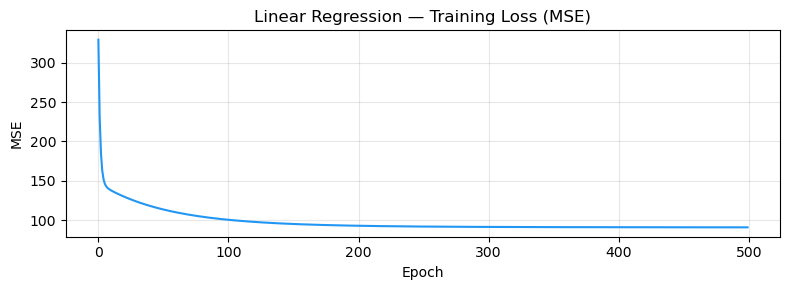

In [20]:
class LinearRegression:
    """Linear Regression via Gradient Descent."""
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        n, m = X.shape
        # Add bias column
        X_b = np.c_[np.ones(n), X]
        self.weights = np.zeros(m + 1)
        self.losses = []

        for _ in range(self.epochs):
            preds = X_b @ self.weights
            error = preds - y
            gradient = (2 / n) * (X_b.T @ error)
            self.weights -= self.lr * gradient
            self.losses.append(np.mean(error ** 2))

    def predict(self, X):
        X_b = np.c_[np.ones(len(X)), X]
        return X_b @ self.weights

# ─── Train & Evaluate ───
lr_model = LinearRegression(lr=0.05, epochs=500)
lr_model.fit(X_train_n, y_train_reg)
y_pred_reg = lr_model.predict(X_test_n)

test_mse = mse(y_test_reg, y_pred_reg)
print(f"{'='*50}")
print(f"  Linear Regression")
print(f"{'='*50}")
print(f"  Test MSE:  {test_mse:.2f}")
print(f"  Test RMSE: {math.sqrt(test_mse):.2f} minutes")
print(f"\n  Sample predictions (actual → predicted):")
for i in range(5):
    print(f"    {y_test_reg[i]:>6.1f} → {y_pred_reg[i]:>6.1f}")

results['Linear Regression'] = {'mse': test_mse, 'rmse': math.sqrt(test_mse)}

# Loss curve
plt.figure(figsize=(8, 3))
plt.plot(lr_model.losses, color='#2196F3', linewidth=1.5)
plt.title('Linear Regression — Training Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 2️⃣ Logistic Regression (Gradient Descent)
> **Type**: Supervised — Classification  
> **Target**: `is_delayed` (binary)  
> **Metric**: Accuracy + Confusion Matrix


  Logistic Regression
  Accuracy: 63.33%
  Confusion Matrix:
              Pred 0   Pred 1
    Actual 0     24       11
    Actual 1     11       14


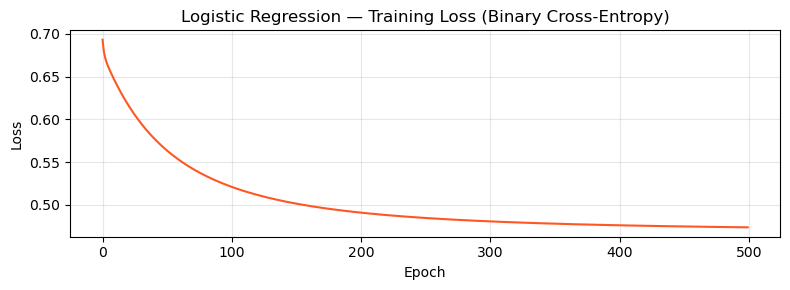

In [21]:
class LogisticRegression:
    """Logistic Regression via Gradient Descent with sigmoid activation."""
    def __init__(self, lr=0.1, epochs=1000):
        self.lr = lr
        self.epochs = epochs

    @staticmethod
    def _sigmoid(z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n, m = X.shape
        X_b = np.c_[np.ones(n), X]
        self.weights = np.zeros(m + 1)
        self.losses = []

        for _ in range(self.epochs):
            preds = self._sigmoid(X_b @ self.weights)
            error = preds - y
            gradient = (1 / n) * (X_b.T @ error)
            self.weights -= self.lr * gradient
            # Binary cross-entropy loss
            eps = 1e-15
            loss = -np.mean(y * np.log(preds + eps) + (1 - y) * np.log(1 - preds + eps))
            self.losses.append(loss)

    def predict_proba(self, X):
        X_b = np.c_[np.ones(len(X)), X]
        return self._sigmoid(X_b @ self.weights)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# ─── Train & Evaluate ───
log_model = LogisticRegression(lr=0.5, epochs=500)
log_model.fit(X_train_n, y_train_cls)
y_pred_log = log_model.predict(X_test_n)

acc_log = print_metrics("Logistic Regression", y_test_cls, y_pred_log)
results['Logistic Regression'] = {'accuracy': acc_log}

# Loss curve
plt.figure(figsize=(8, 3))
plt.plot(log_model.losses, color='#FF5722', linewidth=1.5)
plt.title('Logistic Regression — Training Loss (Binary Cross-Entropy)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 3️⃣ K-Nearest Neighbors (KNN)
> **Type**: Supervised — Instance-based (Lazy Learning)  
> **Target**: `is_delayed` (binary)  
> **Hyperparameter**: k = 5

In [22]:
class KNN:
    """K-Nearest Neighbors classifier using Euclidean distance."""
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _euclidean(self, a, b):
        return np.sqrt(np.sum((a - b) ** 2, axis=1))

    def predict(self, X):
        preds = []
        for x in X:
            dists = self._euclidean(self.X_train, x)
            k_idx = np.argsort(dists)[:self.k]
            k_labels = self.y_train[k_idx]
            # Majority vote
            preds.append(1 if np.sum(k_labels) > self.k / 2 else 0)
        return np.array(preds)

# ─── Train & Evaluate ───
knn = KNN(k=5)
knn.fit(X_train_n, y_train_cls)
y_pred_knn = knn.predict(X_test_n)

acc_knn = print_metrics("K-Nearest Neighbors (k=5)", y_test_cls, y_pred_knn)
results['KNN (k=5)'] = {'accuracy': acc_knn}


  K-Nearest Neighbors (k=5)
  Accuracy: 55.00%
  Confusion Matrix:
              Pred 0   Pred 1
    Actual 0     23       12
    Actual 1     15       10


## 4️⃣ Gaussian Naive Bayes
> **Type**: Supervised — Probabilistic  
> **Target**: `is_delayed` (binary)  
> **Assumption**: Features are conditionally independent given the class, Gaussian-distributed

In [23]:
class GaussianNaiveBayes:
    """Gaussian Naive Bayes classifier using Bayes' theorem + Gaussian PDF."""
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.params = {}  # {class: (mean_vec, var_vec, prior)}
        for c in self.classes:
            X_c = X[y == c]
            self.params[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0) + 1e-9,  # smoothing
                'prior': len(X_c) / len(X)
            }

    def _gaussian_pdf(self, x, mean, var):
        """Compute log of Gaussian PDF to avoid underflow."""
        return -0.5 * np.log(2 * np.pi * var) - 0.5 * ((x - mean) ** 2 / var)

    def predict(self, X):
        preds = []
        for x in X:
            posteriors = {}
            for c in self.classes:
                p = self.params[c]
                log_posterior = np.log(p['prior']) + np.sum(self._gaussian_pdf(x, p['mean'], p['var']))
                posteriors[c] = log_posterior
            preds.append(max(posteriors, key=posteriors.get))
        return np.array(preds)

# ─── Train & Evaluate ───
gnb = GaussianNaiveBayes()
gnb.fit(X_train_n, y_train_cls)
y_pred_gnb = gnb.predict(X_test_n)

acc_gnb = print_metrics("Gaussian Naive Bayes", y_test_cls, y_pred_gnb)
results['Naive Bayes'] = {'accuracy': acc_gnb}

# Show learned class priors
for c in gnb.classes:
    print(f"\n  Class {int(c)} prior: {gnb.params[c]['prior']:.3f}")


  Gaussian Naive Bayes
  Accuracy: 63.33%
  Confusion Matrix:
              Pred 0   Pred 1
    Actual 0     25       10
    Actual 1     12       13

  Class 0 prior: 0.604

  Class 1 prior: 0.396


## 5️⃣ Decision Tree (CART — Gini Impurity)
> **Type**: Supervised — Tree-based  
> **Target**: `is_delayed` (binary)  
> **Split criterion**: Gini Impurity | **Max depth**: 5

In [11]:
class DecisionTree:
    """Decision Tree classifier using CART algorithm with Gini impurity."""
    def __init__(self, max_depth=5, min_samples=2):
        self.max_depth = max_depth
        self.min_samples = min_samples

    def _gini(self, y):
        if len(y) == 0:
            return 0
        p = np.mean(y)
        return 1 - p**2 - (1 - p)**2

    def _best_split(self, X, y):
        best_gain, best_feat, best_thresh = -1, None, None
        parent_gini = self._gini(y)
        n = len(y)

        for feat in range(X.shape[1]):
            thresholds = np.unique(X[:, feat])
            for thresh in thresholds:
                left_mask = X[:, feat] <= thresh
                right_mask = ~left_mask
                if left_mask.sum() < 1 or right_mask.sum() < 1:
                    continue
                gain = parent_gini - (left_mask.sum()/n * self._gini(y[left_mask]) +
                                       right_mask.sum()/n * self._gini(y[right_mask]))
                if gain > best_gain:
                    best_gain, best_feat, best_thresh = gain, feat, thresh
        return best_feat, best_thresh, best_gain

    def _build(self, X, y, depth):
        # Leaf conditions
        if depth >= self.max_depth or len(y) < self.min_samples or len(np.unique(y)) == 1:
            return {'leaf': True, 'val': round(np.mean(y))}

        feat, thresh, gain = self._best_split(X, y)
        if feat is None or gain < 1e-7:
            return {'leaf': True, 'val': round(np.mean(y))}

        left_mask = X[:, feat] <= thresh
        return {
            'leaf': False, 'feat': feat, 'thresh': thresh,
            'left': self._build(X[left_mask], y[left_mask], depth + 1),
            'right': self._build(X[~left_mask], y[~left_mask], depth + 1)
        }

    def fit(self, X, y):
        self.tree = self._build(X, y, 0)

    def _predict_one(self, x, node):
        if node['leaf']:
            return node['val']
        if x[node['feat']] <= node['thresh']:
            return self._predict_one(x, node['left'])
        return self._predict_one(x, node['right'])

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

    def print_tree(self, node=None, indent=""):
        """Text-based tree visualization."""
        if node is None:
            node = self.tree
        if node['leaf']:
            print(f"{indent}→ Predict: {int(node['val'])}")
            return
        print(f"{indent}Feature[{node['feat']}] <= {node['thresh']:.3f}?")
        print(f"{indent}├─ Yes:")
        self.print_tree(node['left'], indent + "│  ")
        print(f"{indent}└─ No:")
        self.print_tree(node['right'], indent + "   ")

# ─── Train & Evaluate ───
dt = DecisionTree(max_depth=5)
dt.fit(X_train_n, y_train_cls)
y_pred_dt = dt.predict(X_test_n)

acc_dt = print_metrics("Decision Tree (depth=5)", y_test_cls, y_pred_dt)
results['Decision Tree'] = {'accuracy': acc_dt}

print("\n  Tree structure (top levels):")
dt.print_tree()


  Decision Tree (depth=5)
  Accuracy: 71.67%
  Confusion Matrix:
              Pred 0   Pred 1
    Actual 0     27        8
    Actual 1      9       16

  Tree structure (top levels):
Feature[6] <= 0.571?
├─ Yes:
│  Feature[7] <= 0.000?
│  ├─ Yes:
│  │  Feature[0] <= 0.913?
│  │  ├─ Yes:
│  │  │  Feature[0] <= 0.304?
│  │  │  ├─ Yes:
│  │  │  │  Feature[6] <= 0.287?
│  │  │  │  ├─ Yes:
│  │  │  │  │  → Predict: 0
│  │  │  │  └─ No:
│  │  │  │     → Predict: 0
│  │  │  └─ No:
│  │  │     Feature[4] <= 0.000?
│  │  │     ├─ Yes:
│  │  │     │  → Predict: 0
│  │  │     └─ No:
│  │  │        → Predict: 0
│  │  └─ No:
│  │     Feature[5] <= 0.129?
│  │     ├─ Yes:
│  │     │  → Predict: 0
│  │     └─ No:
│  │        Feature[1] <= 0.000?
│  │        ├─ Yes:
│  │        │  → Predict: 0
│  │        └─ No:
│  │           → Predict: 1
│  └─ No:
│     Feature[5] <= 0.712?
│     ├─ Yes:
│     │  Feature[3] <= 0.250?
│     │  ├─ Yes:
│     │  │  → Predict: 0
│     │  └─ No:
│     │     Feature[2]

## 6️⃣ Random Forest (Ensemble of Decision Trees)
> **Type**: Supervised — Ensemble (Bagging)  
> **Target**: `is_delayed` (binary)  
> **Config**: 10 trees, bootstrap sampling, random feature subsets

In [12]:
class RandomForest:
    """Random Forest: ensemble of Decision Trees with bootstrap + feature subsampling."""
    def __init__(self, n_trees=10, max_depth=5, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
        self.feature_indices = []

    def fit(self, X, y):
        n, m = X.shape
        if self.max_features is None:
            self.max_features = int(np.sqrt(m))

        for _ in range(self.n_trees):
            # Bootstrap sample
            idx = np.random.choice(n, n, replace=True)
            # Random feature subset
            feat_idx = np.sort(np.random.choice(m, self.max_features, replace=False))
            X_boot = X[idx][:, feat_idx]
            y_boot = y[idx]

            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_boot, y_boot)
            self.trees.append(tree)
            self.feature_indices.append(feat_idx)

    def predict(self, X):
        # Collect votes from all trees
        all_preds = np.array([
            tree.predict(X[:, feat_idx])
            for tree, feat_idx in zip(self.trees, self.feature_indices)
        ])
        # Majority vote (axis=0 → across trees for each sample)
        return (all_preds.mean(axis=0) >= 0.5).astype(int)

# ─── Train & Evaluate ───
rf = RandomForest(n_trees=10, max_depth=5)
rf.fit(X_train_n, y_train_cls)
y_pred_rf = rf.predict(X_test_n)

acc_rf = print_metrics("Random Forest (10 trees)", y_test_cls, y_pred_rf)
results['Random Forest'] = {'accuracy': acc_rf}

# Compare with single Decision Tree
print(f"\n  Single Tree accuracy: {acc_dt*100:.2f}%")
print(f"  Random Forest accuracy: {acc_rf*100:.2f}%")
print(f"  Improvement: {(acc_rf - acc_dt)*100:+.2f}%")


  Random Forest (10 trees)
  Accuracy: 58.33%
  Confusion Matrix:
              Pred 0   Pred 1
    Actual 0     28        7
    Actual 1     18        7

  Single Tree accuracy: 71.67%
  Random Forest accuracy: 58.33%
  Improvement: -13.33%


## 7️⃣ K-Means Clustering (Unsupervised)
> **Type**: Unsupervised — Clustering  
> **No target label used during training**  
> **Config**: k=3 clusters | Post-hoc analysis against `is_delayed`

  Converged at iteration 10

  K-Means Clustering (k=3)
  Cluster 0:  22 samples | Delay rate: 31.8% | Avg delay: 11.6 min
  Cluster 1:  13 samples | Delay rate: 46.2% | Avg delay: 18.6 min
  Cluster 2:  25 samples | Delay rate: 48.0% | Avg delay: 15.8 min

  Inertia (test): 43.00


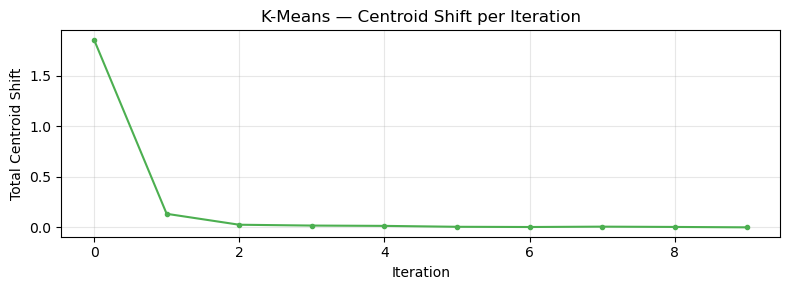

In [13]:
class KMeans:
    """K-Means clustering with iterative centroid updates."""
    def __init__(self, k=3, max_iters=100):
        self.k = k
        self.max_iters = max_iters

    def fit(self, X):
        n, m = X.shape
        # Initialize centroids randomly from data points
        idx = np.random.choice(n, self.k, replace=False)
        self.centroids = X[idx].copy()
        self.history = []

        for iteration in range(self.max_iters):
            # Assign clusters
            dists = np.array([np.sqrt(np.sum((X - c)**2, axis=1)) for c in self.centroids])
            self.labels = np.argmin(dists, axis=0)

            # Update centroids
            new_centroids = np.array([
                X[self.labels == i].mean(axis=0) if np.sum(self.labels == i) > 0 else self.centroids[i]
                for i in range(self.k)
            ])

            # Check convergence
            shift = np.sum((new_centroids - self.centroids) ** 2)
            self.history.append(shift)
            self.centroids = new_centroids
            if shift < 1e-6:
                print(f"  Converged at iteration {iteration + 1}")
                break

        return self.labels

    def predict(self, X):
        dists = np.array([np.sqrt(np.sum((X - c)**2, axis=1)) for c in self.centroids])
        return np.argmin(dists, axis=0)

# ─── Train & Analyze ───
km = KMeans(k=3)
train_labels = km.fit(X_train_n)
test_labels = km.predict(X_test_n)

print(f"\n{'='*50}")
print(f"  K-Means Clustering (k=3)")
print(f"{'='*50}")

# Analyze clusters vs actual delay
for c in range(3):
    mask = test_labels == c
    if mask.sum() == 0:
        continue
    delay_rate = y_test_cls[mask].mean() * 100
    avg_delay = y_test_reg[mask].mean()
    print(f"  Cluster {c}: {mask.sum():>3} samples | Delay rate: {delay_rate:.1f}% | Avg delay: {avg_delay:.1f} min")

# Inertia (sum of squared distances to centroids)
inertia = sum(np.sum((X_test_n[test_labels == i] - km.centroids[i])**2)
              for i in range(3))
print(f"\n  Inertia (test): {inertia:.2f}")
results['K-Means'] = {'inertia': inertia, 'type': 'unsupervised'}

# Convergence plot
plt.figure(figsize=(8, 3))
plt.plot(km.history, color='#4CAF50', linewidth=1.5, marker='o', markersize=3)
plt.title('K-Means — Centroid Shift per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Total Centroid Shift')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8️⃣ Neural Network (1 Hidden Layer — Backpropagation)
> **Type**: Supervised — Neural Network  
> **Target**: `is_delayed` (binary)  
> **Architecture**: 9 inputs → 16 hidden (ReLU) → 1 output (Sigmoid)  
> **Training**: Backpropagation with gradient descent


  Neural Network (16 hidden, ReLU)
  Accuracy: 60.00%
  Confusion Matrix:
              Pred 0   Pred 1
    Actual 0     24       11
    Actual 1     13       12


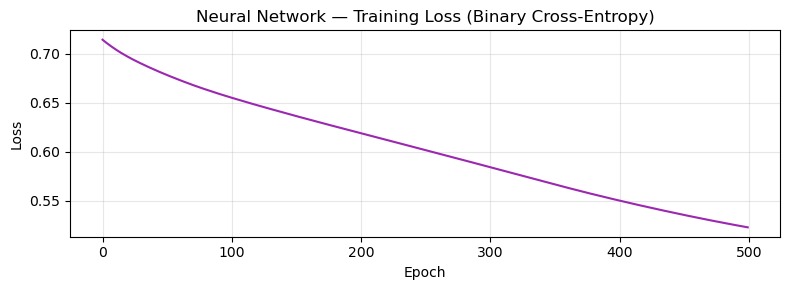

In [14]:
class NeuralNetwork:
    """Simple 1-hidden-layer neural network with backpropagation."""
    def __init__(self, input_size, hidden_size=16, lr=0.05, epochs=500):
        self.lr = lr
        self.epochs = epochs
        # Xavier initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, 1) * np.sqrt(2 / hidden_size)
        self.b2 = np.zeros(1)
        self.losses = []

    @staticmethod
    def _sigmoid(z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def _relu(z):
        return np.maximum(0, z)

    @staticmethod
    def _relu_deriv(z):
        return (z > 0).astype(float)

    def fit(self, X, y):
        y = y.reshape(-1, 1)
        n = len(X)

        for epoch in range(self.epochs):
            # ─── Forward pass ───
            z1 = X @ self.W1 + self.b1           # (n, hidden)
            a1 = self._relu(z1)                    # (n, hidden)
            z2 = a1 @ self.W2 + self.b2           # (n, 1)
            a2 = self._sigmoid(z2)                 # (n, 1)

            # ─── Loss (binary cross-entropy) ───
            eps = 1e-15
            loss = -np.mean(y * np.log(a2 + eps) + (1 - y) * np.log(1 - a2 + eps))
            self.losses.append(loss)

            # ─── Backward pass ───
            dz2 = a2 - y                           # (n, 1)
            dW2 = (1/n) * (a1.T @ dz2)            # (hidden, 1)
            db2 = (1/n) * np.sum(dz2, axis=0)

            da1 = dz2 @ self.W2.T                  # (n, hidden)
            dz1 = da1 * self._relu_deriv(z1)       # (n, hidden)
            dW1 = (1/n) * (X.T @ dz1)             # (input, hidden)
            db1 = (1/n) * np.sum(dz1, axis=0)

            # ─── Update weights ───
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1

    def predict_proba(self, X):
        a1 = self._relu(X @ self.W1 + self.b1)
        return self._sigmoid(a1 @ self.W2 + self.b2).flatten()

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# ─── Train & Evaluate ───
nn = NeuralNetwork(input_size=9, hidden_size=16, lr=0.05, epochs=500)
nn.fit(X_train_n, y_train_cls)
y_pred_nn = nn.predict(X_test_n)

acc_nn = print_metrics("Neural Network (16 hidden, ReLU)", y_test_cls, y_pred_nn)
results['Neural Network'] = {'accuracy': acc_nn}

# Training loss curve
plt.figure(figsize=(8, 3))
plt.plot(nn.losses, color='#9C27B0', linewidth=1.5)
plt.title('Neural Network — Training Loss (Binary Cross-Entropy)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 🎯 Feature Importance Analysis: PDP & ICE
> **Goal**: Understand which features are most influential in model predictions
> - **PDP (Partial Dependence Plot)**: Average effect of a feature on predictions
> - **ICE (Individual Conditional Expectation)**: Per-sample feature effect
> - **Permutation Importance**: Drop in model performance when feature is shuffled

In [ ]:
# ─── Feature Importance using Best Model (Decision Tree) ───
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS using Trained Decision Tree")
print("="*80)

# Baseline prediction
y_pred_baseline = dt.predict(X_test_n)
baseline_acc = accuracy(y_test_cls, y_pred_baseline)
print(f"\nModel Accuracy (Baseline): {baseline_acc*100:.2f}%")

# ─── 1. PERMUTATION IMPORTANCE ───
print(f"\n{'-'*80}")
print("1. PERMUTATION IMPORTANCE (Drop in accuracy when feature is shuffled)")
print(f"{'-'*80}")

perm_importance = {}
for feat_idx in range(X_test_n.shape[1]):
    X_test_perm = permute_feature(X_test_n, feat_idx, seed=42)
    y_pred_perm = dt.predict(X_test_perm)
    acc_perm = accuracy(y_test_cls, y_pred_perm)
    importance = baseline_acc - acc_perm  # Higher drop = more important
    perm_importance[feat_idx] = importance

# Sort and display
perm_sorted = sorted(perm_importance.items(), key=lambda x: abs(x[1]), reverse=True)
print(f"\n{'Feature':<20} {'Name':<20} {'Importance (Δ Acc)':<15}")
print("─" * 55)
for feat_idx, importance in perm_sorted:
    print(f"Feature {feat_idx:<13} {feature_names[feat_idx]:<20} {importance:+.4f}")

# ─── 2. PARTIAL DEPENDENCE PLOT (PDP) ───
print(f"\n{'-'*80}")
print("2. PARTIAL DEPENDENCE PLOT (Average prediction effect per feature)")
print(f"{'-'*80}")

def compute_pdp(model, X, feature_idx, grid_points=10):
    """
    Compute PDP: average prediction change as we vary a single feature.
    PDP = mean(predict(X with feature_j = val)) for various values of feature_j
    """
    X_copy = X.copy()
    feature_range = np.linspace(X[:, feature_idx].min(), X[:, feature_idx].max(), grid_points)
    pdp_values = []
    
    for val in feature_range:
        X_copy[:, feature_idx] = val
        preds_proba = model.predict(X_copy)
        avg_pred = preds_proba.mean()
        pdp_values.append(avg_pred)
    
    return feature_range, np.array(pdp_values)

# Compute PDP for top 3 important features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
top_features = [f_idx for f_idx, _ in perm_sorted[:3]]

for subplot_idx, feat_idx in enumerate(top_features):
    feature_range, pdp_vals = compute_pdp(dt, X_test_n, feat_idx, grid_points=15)
    ax = axes[subplot_idx]
    ax.plot(feature_range, pdp_vals, 'o-', linewidth=2.5, markersize=6, color='#2196F3')
    ax.fill_between(feature_range, pdp_vals, alpha=0.2, color='#2196F3')
    ax.set_xlabel('Feature Value (normalized)', fontsize=11)
    ax.set_ylabel('Avg Predicted Probability\n(is_delayed=1)', fontsize=11)
    ax.set_title(f'PDP: {feature_names[feat_idx]}', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.set_ylim([0, 1])

plt.suptitle('Partial Dependence Plots — Top 3 Important Features', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ─── 3. INDIVIDUAL CONDITIONAL EXPECTATION (ICE) ───
print(f"\n{'-'*80}")
print("3. INDIVIDUAL CONDITIONAL EXPECTATION (Per-sample effect)")
print(f"{'-'*80}")

def compute_ice(model, X, feature_idx, grid_points=15):
    """
    ICE: array of predictions for each sample as we vary feature_idx.
    Returns: (feature_range, predictions_per_sample [n_samples, n_grid_points])
    """
    n_samples = X.shape[0]
    feature_range = np.linspace(X[:, feature_idx].min(), X[:, feature_idx].max(), grid_points)
    ice_curves = np.zeros((n_samples, len(feature_range)))
    
    for col_idx, val in enumerate(feature_range):
        X_copy = X.copy()
        X_copy[:, feature_idx] = val
        ice_curves[:, col_idx] = model.predict(X_copy)
    
    return feature_range, ice_curves

# Plot ICE for top feature
top_feat = perm_sorted[0][0]
feature_range, ice_curves = compute_ice(dt, X_test_n, top_feat, grid_points=15)

fig, ax = plt.subplots(figsize=(10, 5))

# Plot individual curves (light)
for i in range(min(20, ice_curves.shape[0])):
    ax.plot(feature_range, ice_curves[i], color='#FF9800', alpha=0.2, linewidth=0.8)

# Plot average (bold)
pdp_line = ice_curves.mean(axis=0)
ax.plot(feature_range, pdp_line, 'o-', color='#E91E63', linewidth=3, markersize=6, 
        label='PDP (average)', zorder=10)

ax.set_xlabel('Feature Value (normalized)', fontsize=12)
ax.set_ylabel('Predicted Probability (is_delayed=1)', fontsize=12)
ax.set_title(f'ICE & PDP — Feature {top_feat}: {feature_names[top_feat]}', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()

print(f"\nICE curves show individual sample responses to {feature_names[top_feat]}")
print(f"PDP (bold red line) shows the average effect across all samples")

## 📊 Final Comparison — All Models

  CLASSIFICATION MODELS — Accuracy Ranking
  🥇 Decision Tree              71.67%  ████████████████████████████
  🥈 Logistic Regression        63.33%  █████████████████████████
  🥉 Naive Bayes                63.33%  █████████████████████████
     Neural Network             60.00%  ████████████████████████
     Random Forest              58.33%  ███████████████████████
     KNN (k=5)                  55.00%  ██████████████████████

  REGRESSION MODEL
  Linear Regression  MSE: 125.35  |  RMSE: 11.20 min

  UNSUPERVISED MODEL
  K-Means (k=3)     Inertia: 43.00


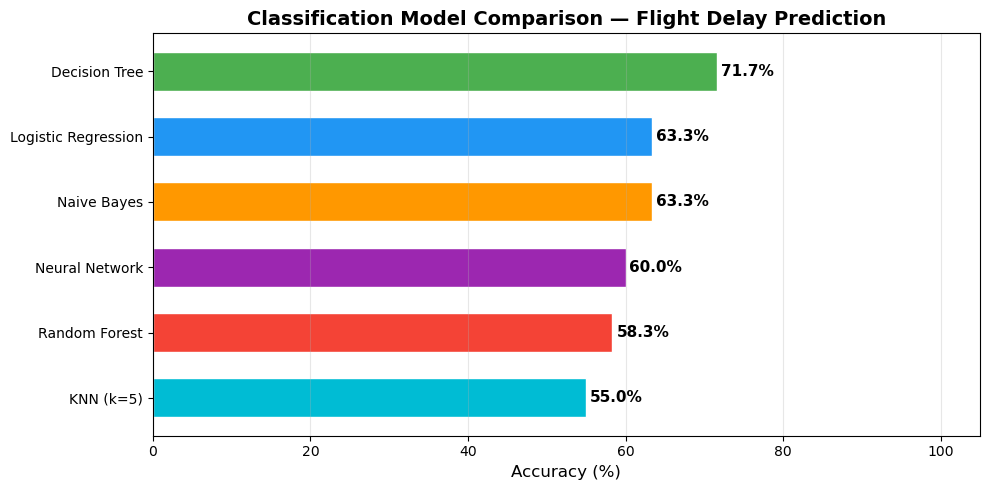


✅ All 8 ML models implemented from scratch using pure Python + NumPy!


In [15]:
# ─── Classification Models Comparison ───
print("=" * 60)
print("  CLASSIFICATION MODELS — Accuracy Ranking")
print("=" * 60)

cls_models = {k: v for k, v in results.items() if 'accuracy' in v}
ranked = sorted(cls_models.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for i, (name, metrics) in enumerate(ranked, 1):
    bar = "█" * int(metrics['accuracy'] * 40)
    medal = ["🥇", "🥈", "🥉"][i-1] if i <= 3 else "  "
    print(f"  {medal} {name:<25} {metrics['accuracy']*100:>6.2f}%  {bar}")

# ─── Regression Model ───
print(f"\n{'='*60}")
print("  REGRESSION MODEL")
print("=" * 60)
print(f"  Linear Regression  MSE: {results['Linear Regression']['mse']:.2f}  |  RMSE: {results['Linear Regression']['rmse']:.2f} min")

# ─── Unsupervised Model ───
print(f"\n{'='*60}")
print("  UNSUPERVISED MODEL")
print("=" * 60)
print(f"  K-Means (k=3)     Inertia: {results['K-Means']['inertia']:.2f}")

# ─── Visual comparison bar chart ───
fig, ax = plt.subplots(figsize=(10, 5))
names = [n for n, _ in ranked]
accs = [v['accuracy'] * 100 for _, v in ranked]
colors = ['#4CAF50', '#2196F3', '#FF9800', '#9C27B0', '#F44336', '#00BCD4']
bars = ax.barh(names[::-1], accs[::-1], color=colors[:len(names)][::-1], edgecolor='white', height=0.6)

for bar, acc in zip(bars, accs[::-1]):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{acc:.1f}%', va='center', fontweight='bold', fontsize=11)

ax.set_xlabel('Accuracy (%)', fontsize=12)
ax.set_title('Classification Model Comparison — Flight Delay Prediction', fontsize=14, fontweight='bold')
ax.set_xlim(0, 105)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ All 8 ML models implemented from scratch using pure Python + NumPy!")